# High-risk Project: Explainable AI for Cardiovascular Risk Prediction from Clinical Notes

## Project Overview
This project is part of a high-risk AI in healthcare assignment. The goal is to predict cardiovascular disease risk from hospital discharge summaries using both traditional NLP (TF-IDF) and advanced contextual embeddings (ClinicalBERT). We also apply SHAP for explainability to identify the most influential features driving the predictions.

The workflow includes:
1. Data extraction from MIMIC-III via BigQuery.
2. Text preprocessing and baseline model training (TF-IDF + Logistic Regression).
3. Contextual embeddings using ClinicalBERT, followed by Logistic Regression and XGBoost classifiers.
4. Explainability analysis using SHAP to compare feature importance between traditional and embedding-based models.

By comparing the performance and interpretability of these methods, we aim to explore whether large language model embeddings can outperform simpler text representations in a real clinical prediction task.


In [6]:
# @title Install Dependencies
# Install necessary libraries for the project
!pip install transformers shap xgboost scikit-learn pandas numpy matplotlib

In [7]:
import torch
torch.cuda.is_available()

True

In [8]:

import os

BASE = "."

DIR_DATA = f"{BASE}/data"
DIR_RESULTS = f"{BASE}/results"
DIR_FIG_METHOD = f"{BASE}/figures/methodology"
DIR_FIG_RESULTS = f"{BASE}/figures/results"
DIR_NOTEBOOK = f"{BASE}/notebook"

for d in [DIR_DATA, DIR_RESULTS, DIR_FIG_METHOD, DIR_FIG_RESULTS, DIR_NOTEBOOK]:
    os.makedirs(d, exist_ok=True)

print("✅ Directories ready. Output path set to current directory.")


✅ Directories ready. Output path set to current directory.


## Load Data (with Auto-Generated Dummy Data)
We attempt to load the real MIMIC-III dataset (`cardio_notes.csv`). If the file is not found (e.g., when running this notebook publicly without private data access), the code will **automatically generate a synthetic dataset**.

This ensures the notebook is fully executable for demonstration purposes without compromising patient privacy.

In [9]:
import pandas as pd
import numpy as np
import os

BASE = "."
DIR_DATA = f"{BASE}/data"
DIR_RESULTS = f"{BASE}/results"

os.makedirs(DIR_DATA, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)


csv_path = f"{DIR_DATA}/cardio_notes.csv"

def create_dummy_data():
    """Generates synthetic data for demonstration when real data is missing."""
    print("⚠️ [Notice] Real MIMIC-III data not found at:", csv_path)
    print("🔄 Generating SYNTHETIC DUMMY DATA for demonstration...")

    dummy_texts = [
        "Patient presents with severe chest pain and history of CAD.",
        "Discharge summary: Patient stable, no cardiac issues reported.",
        "Diagnosed with congestive heart failure (CHF), prescribed lasix.",
        "Routine checkup, blood pressure normal, no complaints.",
        "History of myocardial infarction (MI), now complaining of dyspnea.",
        "Fractured arm from fall, otherwise healthy.",
        "Patient shows signs of coronary artery disease.",
        "Normal recovery from surgery, discharged home.",
        "Hypertension and hyperlipidemia, monitoring required.",
        "No significant medical history."
    ] * 10

    ids = range(10000, 10000 + len(dummy_texts))

    keywords = ['cad', 'heart', 'infarction', 'coronary', 'chf']
    labels = [1 if any(k in t.lower() for k in keywords) else 0 for t in dummy_texts]

    return pd.DataFrame({
        "subject_id": ids,
        "hadm_id": ids,
        "text": dummy_texts,
        "target": labels
    })

if os.path.exists(csv_path):
    print(f"✅ Found local file: {csv_path}")
    df = pd.read_csv(csv_path)
else:
    df = create_dummy_data()

    print("\n" + "="*60)
    print("⚠️  WARNING: RUNNING IN DEMO MODE WITH DUMMY DATA  ⚠️")
    print("="*60)
    print("1. Real MIMIC-III data was not found, so synthetic data is used.")
    print("2. The metrics (Accuracy, AUC) produced here are MEANINGLESS.")
    print("3. This run is ONLY to demonstrate that the code executes without errors.")
    print("="*60 + "\n")

print("Shape:", df.shape)
print("Columns:", list(df.columns))

required_cols = ["subject_id", "hadm_id", "text", "target"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print(f"Warning: Missing columns {missing}, filling with placeholders.")
    for c in missing:
        df[c] = 0

vc = df["target"].value_counts(dropna=False).sort_index()
print("\nTarget distribution:\n", vc)

snap_path = f"{DIR_DATA}/cardio_notes_snapshot.csv"
df.to_csv(snap_path, index=False)
print("Saved snapshot to:", snap_path)

⚠️ [Notice] Real MIMIC-III data not found at: ./data/cardio_notes.csv
🔄 Generating SYNTHETIC DUMMY DATA for demonstration...

⚠️  WARNING: RUNNING IN DEMO MODE WITH DUMMY DATA  ⚠️
1. Real MIMIC-III data was not found, so synthetic data is used.
2. The metrics (Accuracy, AUC) produced here are MEANINGLESS.
3. This run is ONLY to demonstrate that the code executes without errors.

Shape: (100, 4)
Columns: ['subject_id', 'hadm_id', 'text', 'target']

Target distribution:
 target
0    60
1    40
Name: count, dtype: int64
Saved snapshot to: ./data/cardio_notes_snapshot.csv


In [10]:
# @title Preprocessing
import re

def clean_text(text):
    """
    Simple text preprocessing:
    - Lowercase
    - Remove extra whitespace
    - Remove long numeric sequences (anonymization helper)
    """
    t = str(text).lower()
    # Remove newlines and extra spaces
    t = re.sub(r'\s+', ' ', t)
    # Remove long digit sequences (e.g. phone numbers, IDs > 4 digits)
    t = re.sub(r'\d{4,}', '[NUM]', t)
    return t.strip()

# Apply cleaning
print("Running preprocessing...")
df['clean_text'] = df['text'].apply(clean_text)

print("Preprocessing complete. Example:")
print("Original:", df['text'].iloc[0][:50] + "...")
print("Cleaned :", df['clean_text'].iloc[0][:50] + "...")

Running preprocessing...
Preprocessing complete. Example:
Original: Patient presents with severe chest pain and histor...
Cleaned : patient presents with severe chest pain and histor...


### Train-test split
We split the dataset into training and testing sets (80% / 20%), using stratified sampling to maintain the ratio of positive and negative samples in both sets.


In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

# Stratified split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['target'],
    test_size=0.2,
    random_state=42,
    stratify=df['target']
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

# Save splits to CSV (using the directories we set up earlier)
train_df = pd.DataFrame({'clean_text': X_train, 'target': y_train})
test_df  = pd.DataFrame({'clean_text': X_test,  'target': y_test})

train_path = f"{DIR_DATA}/train.csv"
test_path  = f"{DIR_DATA}/test.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"✅ Saved train/test sets to:\n - {train_path}\n - {test_path}")

# Check distribution
print("\nTrain target distribution:\n", y_train.value_counts().sort_index())
print("Test target distribution:\n", y_test.value_counts().sort_index())

Train size: 80 | Test size: 20
✅ Saved train/test sets to:
 - ./data/train.csv
 - ./data/test.csv

Train target distribution:
 target
0    48
1    32
Name: count, dtype: int64
Test target distribution:
 target
0    12
1     8
Name: count, dtype: int64


In [12]:
import os, random, numpy as np, torch
SEED = 42
random.seed(SEED); np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
try:
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
except Exception:
    pass
print("Seed fixed:", SEED)


Seed fixed: 42


### Baseline: TF-IDF + Logistic Regression
We vectorize the text using TF-IDF (term frequency–inverse document frequency) with unigrams and bigrams, and train a Logistic Regression classifier as the baseline model. This approach is simple, fast, and interpretable.


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import pandas as pd
import os
import json

# 1. Vectorization
print("Vectorizing text...")
# Limit features to 5000 to keep it manageable
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 2. Training
print("Training Logistic Regression...")
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(X_train_tfidf, y_train)

# 3. Prediction & Evaluation
y_pred = clf.predict(X_test_tfidf)
acc_val = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_val:.4f}")

# Classification Report
rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
pd.DataFrame(rep).transpose().to_csv(f"{DIR_RESULTS}/baseline_results.csv")

# 4. AUC Calculation
auc_val = None
try:
    # LR has predict_proba
    probs = clf.predict_proba(X_test_tfidf)[:, 1]
    auc_val = roc_auc_score(y_test, probs)
    print(f"AUC: {auc_val:.4f}")
except Exception as e:
    print(f"AUC compute error (possibly single class in dummy data): {e}")

# 5. Save Aggregated Results (Prevent duplicates)
row = {
    "model": "TFIDF_LR",
    "accuracy": float(acc_val),
    "macro_f1": rep.get("macro avg", {}).get("f1-score", 0),
    "auc": float(auc_val) if auc_val is not None else None
}

agg_path = f"{DIR_RESULTS}/results_all_models.csv"
if os.path.exists(agg_path):
    prev = pd.read_csv(agg_path)
    # Append and drop duplicates to keep file clean
    new_df = pd.concat([prev, pd.DataFrame([row])], ignore_index=True)
    new_df.drop_duplicates(subset=["model"], keep="last", inplace=True)
    new_df.to_csv(agg_path, index=False)
else:
    pd.DataFrame([row]).to_csv(agg_path, index=False)

print("Saved results to:", agg_path)

# 6. Update metrics.json (for easy parsing later)
metrics_json_path = f"{DIR_RESULTS}/metrics.json"
try:
    data = json.load(open(metrics_json_path)) if os.path.exists(metrics_json_path) else {}
except:
    data = {}

data["baseline_tfidf_logreg_acc"] = float(acc_val)
if auc_val: data["baseline_tfidf_logreg_auc"] = float(auc_val)

with open(metrics_json_path, "w") as f:
    json.dump(data, f, indent=2)
print("Updated metrics.json")

Vectorizing text...
Training Logistic Regression...
Accuracy: 1.0000
AUC: 1.0000
Saved results to: ./results/results_all_models.csv
Updated metrics.json


### SHAP explainability for the baseline
We use SHAP (SHapley Additive exPlanations) to identify the most important words influencing the baseline model's predictions. The summary plot shows both the magnitude and direction of each feature's impact.


Running SHAP analysis for TF-IDF...


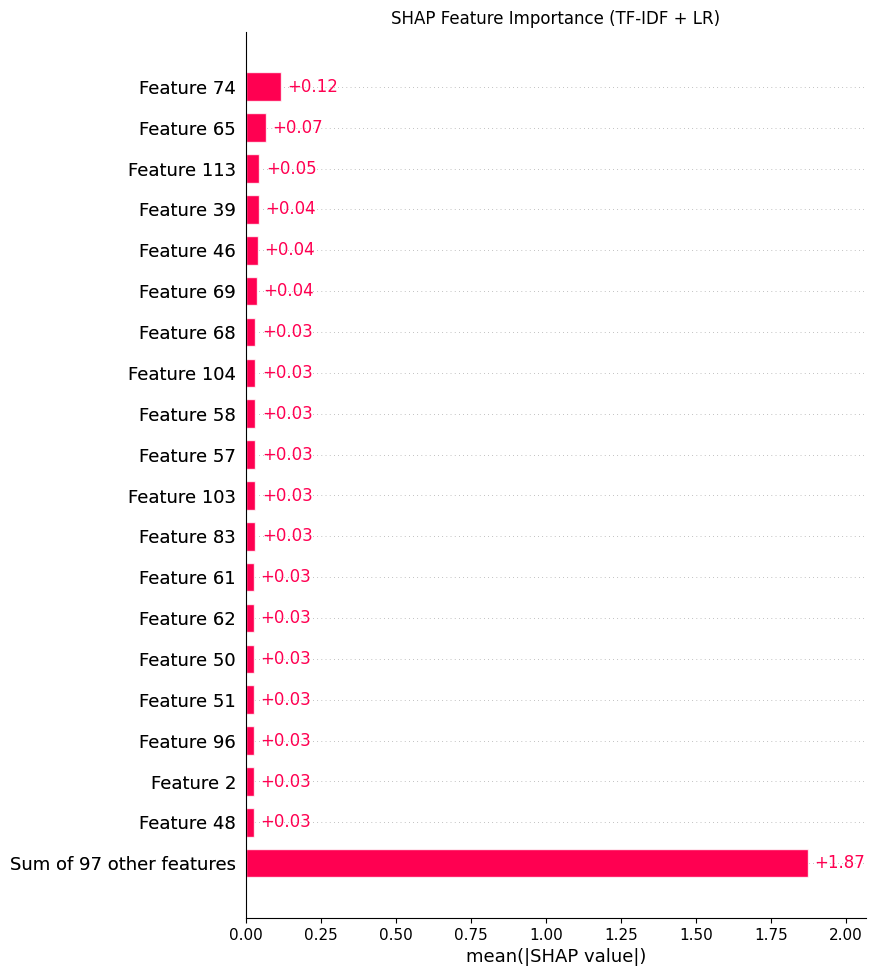

/tmp/ipython-input-2986151407.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv.values, X_sample_dense, feature_names=feature_names, max_display=20, show=False)


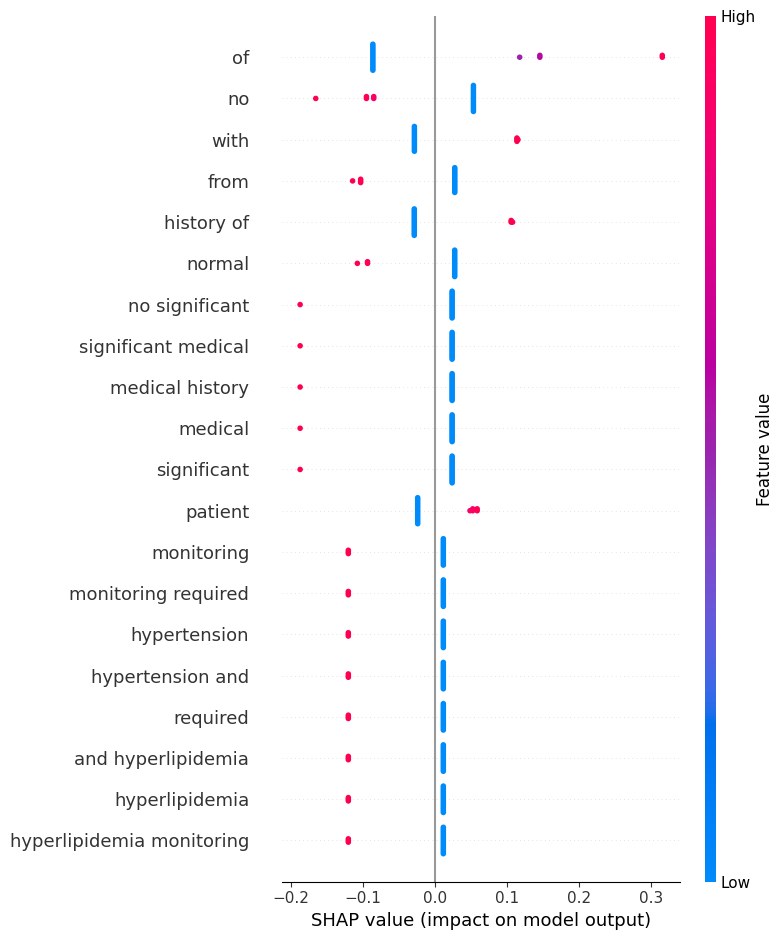

✅ SHAP plots saved to: ./figures/results


In [14]:
import shap
import matplotlib.pyplot as plt
import numpy as np

print("Running SHAP analysis for TF-IDF...")

# 1. Setup SHAP Explainer
# Use a background set (summarized via k-means or just sampling)
# Since TF-IDF is sparse, we pass the sparse matrix directly to LinearExplainer
# Independent masker is good for linear models
masker = shap.maskers.Independent(X_train_tfidf, max_samples=100)
explainer = shap.LinearExplainer(clf, masker=masker)

# 2. Calculate SHAP values for a subset of test data
# Cap sample size to 1000 or full test size
sample_size = min(1000, X_test_tfidf.shape[0])
X_sample = X_test_tfidf[:sample_size]
sv = explainer(X_sample)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# 3. Plot & Save: Bar Plot (Global Importance)
plt.figure(figsize=(10, 6))
shap.plots.bar(sv, max_display=20, show=False)
plt.title("SHAP Feature Importance (TF-IDF + LR)")
plt.savefig(f"{DIR_FIG_RESULTS}/shap_tfidf_bar.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{DIR_FIG_RESULTS}/shap_tfidf_bar.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# 4. Plot & Save: Summary Plot (Directionality)
# Summary plot needs dense matrix for color coding feature values
X_sample_dense = X_sample.toarray()

plt.figure(figsize=(10, 6))
shap.summary_plot(sv.values, X_sample_dense, feature_names=feature_names, max_display=20, show=False)
plt.savefig(f"{DIR_FIG_RESULTS}/shap_tfidf_summary.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{DIR_FIG_RESULTS}/shap_tfidf_summary.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"✅ SHAP plots saved to: {DIR_FIG_RESULTS}")

### ClinicalBERT embeddings
We use the pre-trained ClinicalBERT model to encode the discharge summaries into dense semantic vectors. Mean pooling is applied over token embeddings to produce one fixed-size vector (768 dimensions) per note.


In [15]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import numpy as np
import os

print("🚀 Loading ClinicalBERT model...")

# 1. Setup Device & Model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"   Device: {device}")

model_name = "emilyalsentzer/Bio_ClinicalBERT"
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    bert = AutoModel.from_pretrained(model_name).to(device)
    bert.eval()
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    # Fallback or exit logic if needed

# 2. Define Embedding Function
def batch_embed(texts, batch_size=32, max_length=256, pool='mean'):
    """
    Generates embeddings in batches to avoid OOM errors.
    pool='mean' -> Average pooling (ignoring padding).
    """
    embs = []
    # Ensure texts is a list
    text_list = texts.tolist() if hasattr(texts, "tolist") else list(texts)

    # Progress bar
    for i in tqdm(range(0, len(text_list), batch_size), desc="Embedding"):
        batch = text_list[i:i+batch_size]

        # Tokenize
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            out = bert(**enc)

            if pool == 'cls':
                # Use [CLS] token
                v = out.last_hidden_state[:, 0, :]
            else:
                # Mean pooling with attention mask
                mask = enc.attention_mask.unsqueeze(-1)  # [B, L, 1]
                # Sum of token embeddings (excluding padding)
                summed = (out.last_hidden_state * mask).sum(dim=1)
                # Count of valid tokens
                counts = mask.sum(dim=1).clamp(min=1)
                v = summed / counts

        embs.append(v.detach().cpu())

    # Concatenate all batches
    return torch.vstack(embs).numpy()

# 3. Run Embedding
print("\nGenerating embeddings for Training set...")
Xtr_emb = batch_embed(X_train, batch_size=32)

print("Generating embeddings for Test set...")
Xte_emb = batch_embed(X_test, batch_size=32)

print(f"\nEmbeddings shape: Train {Xtr_emb.shape} | Test {Xte_emb.shape}")

# 4. Save to Disk (as .npy)
# Save to the local data directory defined earlier
np.save(f"{DIR_DATA}/Xtr_emb_clinicalbert.npy", Xtr_emb)
np.save(f"{DIR_DATA}/Xte_emb_clinicalbert.npy", Xte_emb)

# Save a subset for quick SHAP analysis later (optional but helpful)
np.save(f"{DIR_DATA}/Xte_emb_clinicalbert_sample1000.npy", Xte_emb[:1000])

print(f"✅ Saved embeddings to {DIR_DATA}/")


🚀 Loading ClinicalBERT model...
   Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

✅ Model loaded successfully.

Generating embeddings for Training set...


Embedding:   0%|          | 0/3 [00:00<?, ?it/s]

Generating embeddings for Test set...


Embedding:   0%|          | 0/1 [00:00<?, ?it/s]


Embeddings shape: Train (80, 768) | Test (20, 768)
✅ Saved embeddings to ./data/


### ClinicalBERT + Logistic Regression
We train a Logistic Regression classifier using the ClinicalBERT embeddings as features. This tests whether contextual embeddings improve prediction performance compared to the TF-IDF baseline.


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import pandas as pd
import json
import os

print("🚀 Training ClinicalBERT + Logistic Regression...")

# 1. Train Model
# Increase max_iter to ensure convergence
lr = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
lr.fit(Xtr_emb, y_train)

# 2. Predict & Evaluate
pred = lr.predict(Xte_emb)
acc_lr = accuracy_score(y_test, pred)
print(f"Accuracy: {acc_lr:.4f}")

# Save detailed report
rep_lr = classification_report(y_test, pred, output_dict=True, zero_division=0)
pd.DataFrame(rep_lr).transpose().to_csv(f"{DIR_RESULTS}/clinicalbert_lr_results.csv")

# 3. Calculate AUC
auc_lr = None
try:
    probs = lr.predict_proba(Xte_emb)[:, 1]
    auc_lr = roc_auc_score(y_test, probs)
    print(f"AUC: {auc_lr:.4f}")
except Exception as e:
    print(f"AUC compute error: {e}")

# 4. Save Aggregated Results (Prevent duplicates)
row_lr = {
    "model": "ClinicalBERT_LR",
    "accuracy": float(acc_lr),
    "macro_f1": rep_lr.get("macro avg", {}).get("f1-score", 0),
    "auc": float(auc_lr) if auc_lr is not None else None
}

agg_path = f"{DIR_RESULTS}/results_all_models.csv"
if os.path.exists(agg_path):
    prev = pd.read_csv(agg_path)
    new_df = pd.concat([prev, pd.DataFrame([row_lr])], ignore_index=True)
    # Drop duplicates to keep file clean
    new_df.drop_duplicates(subset=["model"], keep="last", inplace=True)
    new_df.to_csv(agg_path, index=False)
else:
    pd.DataFrame([row_lr]).to_csv(agg_path, index=False)

# 5. Update metrics.json
metrics_json_path = f"{DIR_RESULTS}/metrics.json"
try:
    data = json.load(open(metrics_json_path)) if os.path.exists(metrics_json_path) else {}
except:
    data = {}

data["clinicalbert_lr_acc"] = float(acc_lr)
if auc_lr: data["clinicalbert_lr_auc"] = float(auc_lr)

with open(metrics_json_path, "w") as f:
    json.dump(data, f, indent=2)

print("✅ Results saved.")

🚀 Training ClinicalBERT + Logistic Regression...
Accuracy: 1.0000
AUC: 1.0000
✅ Results saved.


Running SHAP analysis for ClinicalBERT + LR...


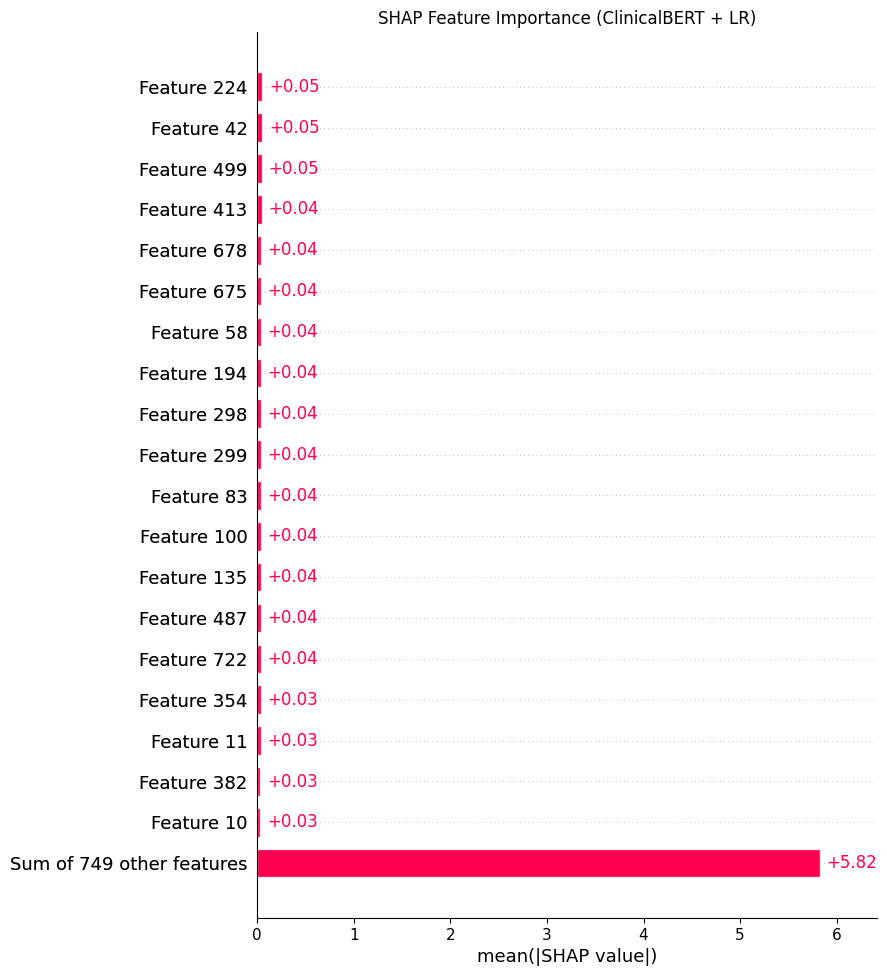

✅ SHAP plots saved to: ./figures/results/shap_clinicalbert_lr_bar.png


In [17]:
import shap
import matplotlib.pyplot as plt

print("Running SHAP analysis for ClinicalBERT + LR...")

# 1. Setup Explainer
# LinearExplainer works well with LR on embeddings
# We use Xtr_emb as background distribution
explainer_lr = shap.LinearExplainer(lr, Xtr_emb)

# 2. Calculate SHAP values
# Sample at most 1000 points
sample_size = min(1000, Xte_emb.shape[0])
X_sample = Xte_emb[:sample_size]
sv_lr = explainer_lr(X_sample)

# 3. Plot & Save: Bar Plot
plt.figure(figsize=(10, 6))
# max_display=20 shows top 20 embedding dimensions
shap.plots.bar(sv_lr, max_display=20, show=False)
plt.title("SHAP Feature Importance (ClinicalBERT + LR)")
plt.savefig(f"{DIR_FIG_RESULTS}/shap_clinicalbert_lr_bar.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{DIR_FIG_RESULTS}/shap_clinicalbert_lr_bar.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"✅ SHAP plots saved to: {DIR_FIG_RESULTS}/shap_clinicalbert_lr_bar.png")

### ClinicalBERT + XGBoost
We train an XGBoost classifier on ClinicalBERT embeddings. XGBoost can model nonlinear feature interactions, which may capture more complex patterns in the semantic embeddings.


In [18]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
import pandas as pd
import json
import os

print("🚀 Training ClinicalBERT + XGBoost...")

# 1. Train Model
# Added random_state for reproducibility
xgb_clf = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",  # Efficient for larger data
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(Xtr_emb, y_train)

# 2. Predict & Evaluate
pred_x = xgb_clf.predict(Xte_emb)
# Get probability for class 1
proba_x = xgb_clf.predict_proba(Xte_emb)[:, 1]

acc_xgb = accuracy_score(y_test, pred_x)
print(f"ClinicalBERT+XGB Accuracy: {acc_xgb:.4f}")

# Save detailed report
rep_xgb = classification_report(y_test, pred_x, output_dict=True, zero_division=0)
pd.DataFrame(rep_xgb).transpose().to_csv(f"{DIR_RESULTS}/clinicalbert_xgb_results.csv")

# 3. Calculate AUC
auc_xgb = roc_auc_score(y_test, proba_x)
print(f"AUC: {auc_xgb:.4f}")

# 4. Save Aggregated Results (Prevent duplicates)
row_xgb = {
    "model": "ClinicalBERT_XGB",
    "accuracy": float(acc_xgb),
    "macro_f1": rep_xgb.get("macro avg", {}).get("f1-score", 0),
    "auc": float(auc_xgb)
}

agg_path = f"{DIR_RESULTS}/results_all_models.csv"
if os.path.exists(agg_path):
    prev = pd.read_csv(agg_path)
    new_df = pd.concat([prev, pd.DataFrame([row_xgb])], ignore_index=True)
    # Drop duplicates to keep file clean
    new_df.drop_duplicates(subset=["model"], keep="last", inplace=True)
    new_df.to_csv(agg_path, index=False)
else:
    pd.DataFrame([row_xgb]).to_csv(agg_path, index=False)

# 5. Update metrics.json
metrics_json_path = f"{DIR_RESULTS}/metrics.json"
try:
    data = json.load(open(metrics_json_path)) if os.path.exists(metrics_json_path) else {}
except:
    data = {}

data["clinicalbert_xgb_acc"] = float(acc_xgb)
data["clinicalbert_xgb_auc"] = float(auc_xgb)

with open(metrics_json_path, "w") as f:
    json.dump(data, f, indent=2)

print("✅ Results saved.")

🚀 Training ClinicalBERT + XGBoost...
ClinicalBERT+XGB Accuracy: 1.0000
AUC: 1.0000
✅ Results saved.


Running SHAP analysis for XGBoost...


/tmp/ipython-input-555637262.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_xgb, X_sample, max_display=20, show=False)


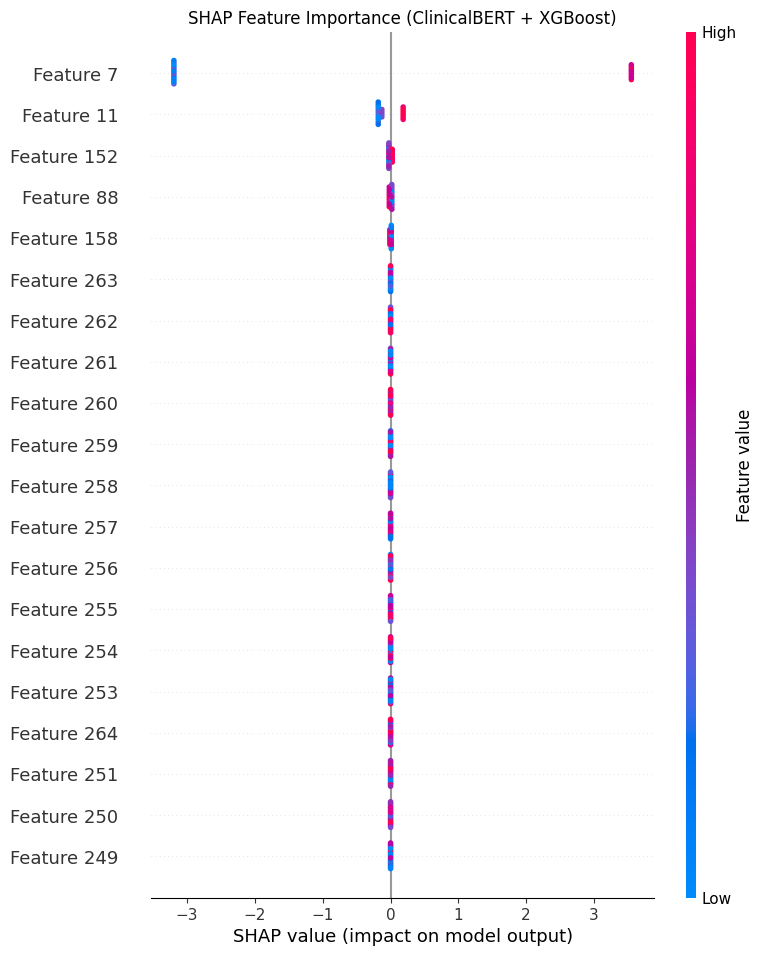

✅ SHAP plots saved to: ./figures/results/shap_clinicalbert_xgb_summary.png


In [19]:
import shap
import matplotlib.pyplot as plt

print("Running SHAP analysis for XGBoost...")

# 1. Setup Explainer
# TreeExplainer is optimized for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_clf)

# 2. Calculate SHAP values
# Sample at most 1000 points
sample_size = min(1000, Xte_emb.shape[0])
X_sample = Xte_emb[:sample_size]

# Calculate shap values
sv_xgb = explainer_xgb.shap_values(X_sample)

# 3. Plot & Save: Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(sv_xgb, X_sample, max_display=20, show=False)
plt.title("SHAP Feature Importance (ClinicalBERT + XGBoost)")
plt.savefig(f"{DIR_FIG_RESULTS}/shap_clinicalbert_xgb_summary.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{DIR_FIG_RESULTS}/shap_clinicalbert_xgb_summary.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"✅ SHAP plots saved to: {DIR_FIG_RESULTS}/shap_clinicalbert_xgb_summary.png")

## roc_comparison

🎨 Generating ROC Curve and LaTeX Table...


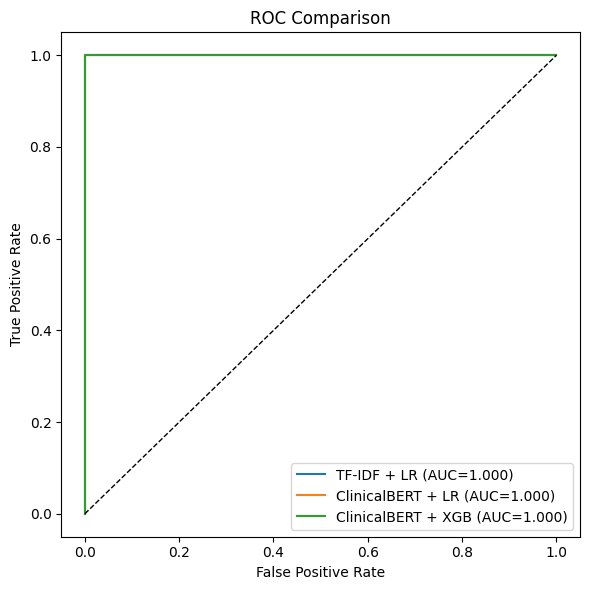

✅ ROC Curve saved to ./figures/results

--- Copy this LaTeX code into your Overleaf ---
\begin{table}[htbp]
\caption{Model performance comparison.}
\label{tab:results}
\centering
\begin{tabular}{lccc}
\toprule
Model & Accuracy & Macro F1 & AUC \\
\midrule
TF-IDF + LR & 1.0000 & 1.0000 & 1.0000 \\
ClinicalBERT + LR & 1.0000 & 1.0000 & 1.0000 \\
ClinicalBERT + XGB & 1.0000 & 1.0000 & 1.0000 \\
\bottomrule
\end{tabular}
\end{table}
----------------------------------------------


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd

print("🎨 Generating ROC Curve and LaTeX Table...")

# === Part 1: ROC Curve Plot ===
plt.figure(figsize=(6, 6))

# Plot TF-IDF (clf)
# Note: Check if model exists, handles dummy data scenarios
if 'clf' in globals():
    probs = clf.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'TF-IDF + LR (AUC={auc(fpr, tpr):.3f})')

# Plot ClinicalBERT + LR (lr)
if 'lr' in globals():
    probs = lr.predict_proba(Xte_emb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'ClinicalBERT + LR (AUC={auc(fpr, tpr):.3f})')

# Plot ClinicalBERT + XGB (xgb_clf)
if 'xgb_clf' in globals():
    probs = xgb_clf.predict_proba(Xte_emb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'ClinicalBERT + XGB (AUC={auc(fpr, tpr):.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison')
plt.legend(loc='lower right')
plt.tight_layout()

# Save
plt.savefig(f"{DIR_FIG_RESULTS}/roc_comparison.png", dpi=300)
plt.savefig(f"{DIR_FIG_RESULTS}/roc_comparison.pdf", dpi=300)
plt.show()
plt.close()
print(f"✅ ROC Curve saved to {DIR_FIG_RESULTS}")


# === Part 2: Generate LaTeX Table ===
# Read the aggregated results
if os.path.exists(agg_path):
    tbl = pd.read_csv(agg_path)

    # Format numbers
    tbl['accuracy'] = tbl['accuracy'].apply(lambda x: f"{x:.4f}")
    tbl['macro_f1'] = tbl['macro_f1'].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else "-")
    tbl['auc'] = tbl['auc'].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else "-")

    # Map names to pretty strings
    name_map = {
        "TFIDF_LR": "TF-IDF + LR",
        "ClinicalBERT_LR": "ClinicalBERT + LR",
        "ClinicalBERT_XGB": "ClinicalBERT + XGB"
    }

    print("\n--- Copy this LaTeX code into your Overleaf ---")
    print(r"\begin{table}[htbp]")
    print(r"\caption{Model performance comparison.}")
    print(r"\label{tab:results}")
    print(r"\centering")
    print(r"\begin{tabular}{lccc}")
    print(r"\toprule")
    print(r"Model & Accuracy & Macro F1 & AUC \\")
    print(r"\midrule")

    for _, r in tbl.iterrows():
        model_name = name_map.get(r['model'], r['model'])
        print(f"{model_name} & {r['accuracy']} & {r['macro_f1']} & {r['auc']} \\\\")

    print(r"\bottomrule")
    print(r"\end{tabular}")
    print(r"\end{table}")
    print("----------------------------------------------")

In [21]:
# @title Generate Diagrams (Figures 1 & 2)
# Install Graphviz (System dependency)
!apt-get -y install graphviz > /dev/null 2>&1
!pip install graphviz

from graphviz import Digraph
import os

print("🎨 Generating Project Diagrams...")

# Helper function
def render_both(g, save_dir, filename):
    g.format = "png"
    g.render(filename=os.path.join(save_dir, filename), cleanup=True)
    g.format = "pdf"
    g.render(filename=os.path.join(save_dir, filename), cleanup=True)
    print(f"   Saved {filename} (.png & .pdf)")

# --- Figure 1: Data Extraction ---
g1 = Digraph('data_extraction')
g1.attr(rankdir='LR', fontsize='12', fontname='Helvetica')

g1.node('D', 'MIMIC-III\n(ICD-9 410-414, 428)', shape='database', style='filled', fillcolor='#E0F7FA')
g1.node('P', 'Preprocessing\n(Filter, Clean, Split)', shape='box', style='filled', fillcolor='#FFF3E0')
g1.node('csv', 'Labeled Dataset\n(Train/Test CSV)', shape='note', style='filled', fillcolor='#F1F8E9')

g1.edge('D', 'P', label=' Extract')
g1.edge('P', 'csv', label=' Save')

render_both(g1, DIR_FIG_METHOD, 'fig_data_extraction')


# --- Figure 2: Model Pipeline ---
g2 = Digraph('model_pipeline')
g2.attr(rankdir='LR', fontsize='12', fontname='Helvetica')

g2.node('In', 'Clinical Text', shape='note')
g2.node('TF', 'TF-IDF\n(n-grams)', shape='box', style='rounded')
g2.node('BERT', 'ClinicalBERT\n(Embeddings)', shape='box', style='rounded')

g2.node('LR1', 'Logistic Regression', shape='ellipse', style='filled', fillcolor='#E1BEE7')
g2.node('LR2', 'Logistic Regression', shape='ellipse', style='filled', fillcolor='#E1BEE7')
g2.node('XGB', 'XGBoost', shape='ellipse', style='filled', fillcolor='#FFCCBC')

g2.edge('In', 'TF')
g2.edge('In', 'BERT')

g2.edge('TF', 'LR1')
g2.edge('BERT', 'LR2')
g2.edge('BERT', 'XGB')

render_both(g2, DIR_FIG_METHOD, 'fig_model_pipeline')
print("✅ Diagrams generated in", DIR_FIG_METHOD)

🎨 Generating Project Diagrams...
   Saved fig_data_extraction (.png & .pdf)
   Saved fig_model_pipeline (.png & .pdf)
✅ Diagrams generated in ./figures/methodology


In [22]:
# @title Bundle & Verify
import glob
import shutil

print("📦 Verifying Outputs...")
print(f"   Data: {len(glob.glob(f'{DIR_DATA}/*'))} files")
print(f"   Results: {len(glob.glob(f'{DIR_RESULTS}/*'))} files")
print(f"   Figures: {len(glob.glob(f'{DIR_FIG_RESULTS}/*'))} files")

# Create a zip bundle for easy download
shutil.make_archive('project_submission', 'zip', BASE)

print("\n🎉 ALL DONE! You can now download 'project_submission.zip' from the file browser on the left.")
print("   This zip contains your Code, Data (dummy), Results, and Figures.")

📦 Verifying Outputs...
   Data: 6 files
   Results: 5 files
   Figures: 10 files

🎉 ALL DONE! You can now download 'project_submission.zip' from the file browser on the left.
   This zip contains your Code, Data (dummy), Results, and Figures.
